In [1]:
import numpy as np
from visualisation2 import xyz_projections

In [2]:
# First example: the homonuclear diatomic
# First read in the data:
molecule_data = np.loadtxt('rigid_rotor.dat')
print(molecule_data)

[[ 1.  1.  1.  1.]
 [-1. -1. -1.  1.]]


In [3]:
# Use array slicing to unpack this into "coordinates" and "masses" array:
coordinates = molecule_data[:,:3]
print(coordinates)
masses = molecule_data[:,3]
print(masses)

[[ 1.  1.  1.]
 [-1. -1. -1.]]
[1. 1.]


/Users/bjm42/Documents/Work/Teaching/ch40208/week_9/exercise/visualisation2.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


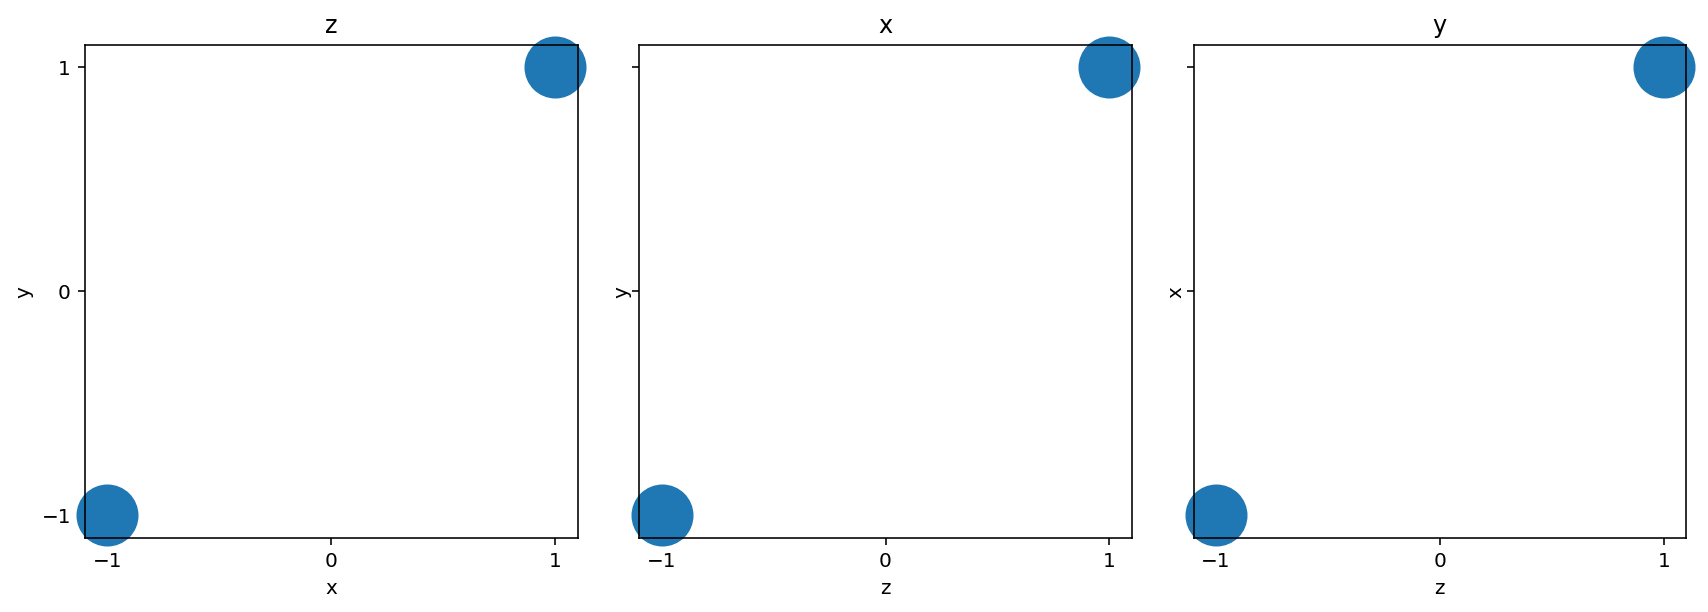

In [4]:
# what does the current orientation of the molecule look like?
xyz_projections(coordinates)

In [5]:
# The molecule is aligned along the [1,1,1] axis
# (it looks "diagonal" when projected along all three axes)

In [6]:
# Constructing the inertia matrix.
# This is comprised of 6 components (equations given in the handout)
# To keep the notation simple I first get the x, y, and z components for each molecule:
x = coordinates[:,0]
y = coordinates[:,1]
z = coordinates[:,2]
# x, y, and z are now lists with two numbers in (because we have 2 atoms)

In [7]:
# Using numpy's ability to perform operations on every element in an array
# e.g. x*y gives [x[0]*y[0], x[1]*y[1]]
xx = x**2
yy = y**2
zz = z**2
xy = x*y
xz = x*z
yz = y*z

In [8]:
I_xx = np.sum((yy+zz)*masses)
I_yy = np.sum((xx+zz)*masses)
I_zz = np.sum((xx+yy)*masses)
I_xy = -np.sum((xy)*masses)
I_xz = -np.sum((xz)*masses)
I_yz = -np.sum((yz)*masses)
# Note the mass weighting.

In [9]:
# now construct the full inertia matrix
I = np.array([[ I_xx, I_xy, I_xz],
              [ I_xy, I_yy, I_yz],
              [ I_xz, I_yz, I_zz]])

In [10]:
# Phew. We get the same matrix as in the demo.
print(I)

[[ 4. -2. -2.]
 [-2.  4. -2.]
 [-2. -2.  4.]]


In [11]:
# From this matrix we can find the principal moments of inertia (eigenvalues of I)
# and the principal rotation axes (eigenvectors of I)
eigenvalues, eigenvectors = np.linalg.eig(I)
print('eigenvalues =\n',eigenvalues) # \n gives a new line.
print('eigenvectors =\n',eigenvectors) # \n gives a new line.

eigenvalues =
 [ 6.0000000e+00 -4.4408921e-16  6.0000000e+00]
eigenvectors =
 [[ 0.81649658 -0.57735027  0.29329423]
 [-0.40824829 -0.57735027 -0.80655913]
 [-0.40824829 -0.57735027  0.5132649 ]]


In [12]:
# The eigenvectors are the *columns* of the second output. 
# Note the second column is a vector oriented along [-1, -1, -1], i.e. our molecular axis.
# The other two eigenvectors are perpendicular (orthogonal) to the molecular axis.

# Also note the eigenvalues associated with each eigenvector.
# The eigenvalue (moment of inertia) associate with rotation about [-1,-1,-1] is 0 (within numerical precision)
# This is because there is no rotational energy (momentum) associated with rotating around the molecular axis.
# The other two principal axes both have moments of inertia of 6 associated with them. 
# The symmetry of this simple molecule means that our choice of perpendicular rotation axis does
# not change the calcualted moment of inertia.

# Does this agree with the way we would normally calculate the moment of inertia for a linear diatomic?

In [13]:
mu = masses[0]*masses[1]/(masses[0]+masses[1])
print(mu)

0.5


In [14]:
r = np.linalg.norm(coordinates[0]-coordinates[1])
print(r)

3.4641016151377544


In [15]:
simple_I = mu*r**2
print(simple_I)

5.999999999999999


In [16]:
# this result == 6 within numerical precision.

In [17]:
# Rotation the molecule so that the principal axes are aligned with the "cell" axes (our coordinate system)
# We want the rotation matrix given by the *inverse* of the eigenvector matrix 
# (the reason for this is discussed in the handout)
R = np.linalg.inv(eigenvectors)
print(R)

[[ 8.16496581e-01 -1.36082763e-01 -6.80413817e-01]
 [-5.77350269e-01 -5.77350269e-01 -5.77350269e-01]
 [-1.26178528e-16 -7.57676761e-01  7.57676761e-01]]


In [18]:
new_coordinates = [] # create an empty list to store out new coordinates
for c in coordinates:
    new_coordinates.append(np.matmul(R,c)) 
new_coordinates = np.array(new_coordinates) # covert our list into a 2D numpy array
print(new_coordinates) 

[[ 3.33066907e-16 -1.73205081e+00 -4.44089210e-16]
 [-3.33066907e-16  1.73205081e+00  4.44089210e-16]]


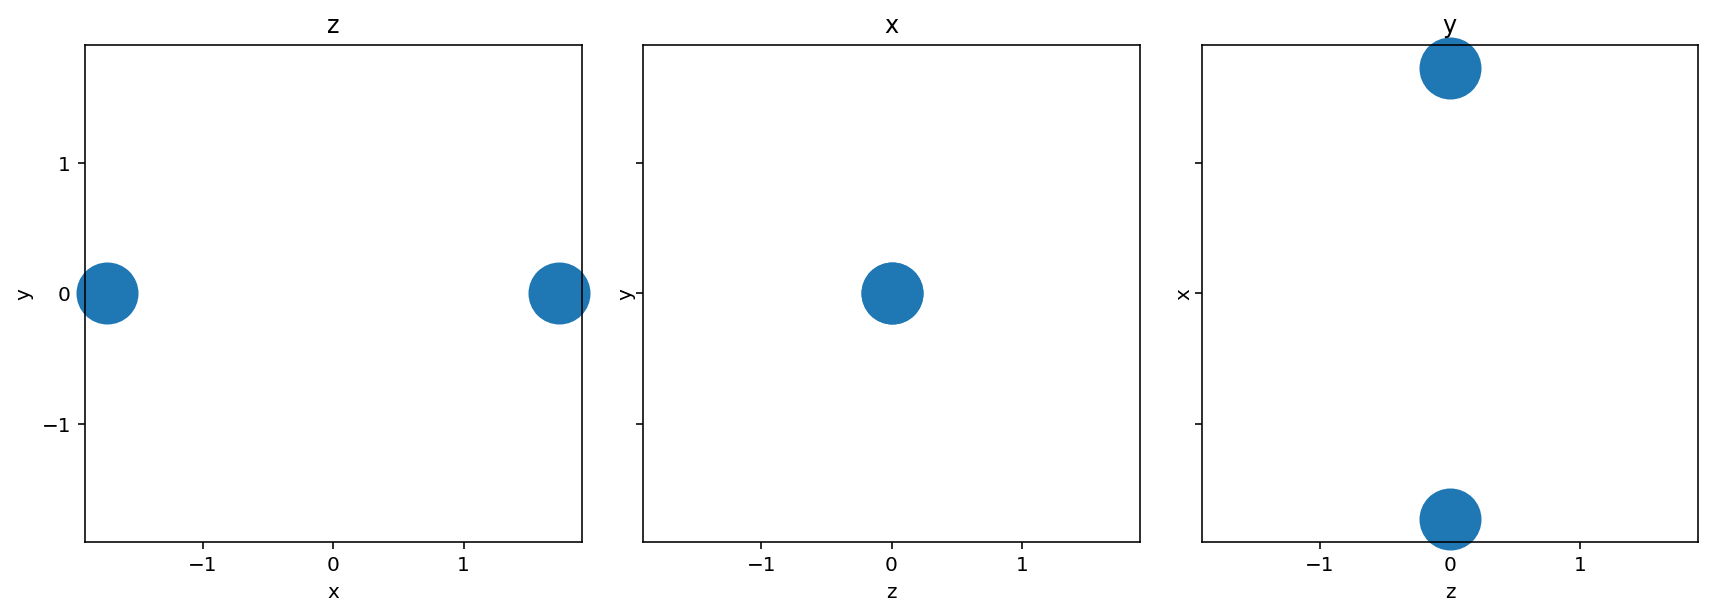

In [19]:
xyz_projections(new_coordinates)

In [20]:
# The terms in the inertia matrix are defined with respect to the centre of mass (COM) for the molecule. 
# In this case the COM was already at (0,0,0) in the input structure, but this is not always the case.
# Let's create a function to calculate the COM
def centre_of_mass(coords, masses):
    """Calculate the centre of mass of a molecule.
    
    Args:
        coords (np.array): 3xN array of (x,y,z) atomic coordinates.
        masses (np.array): 1xN array of atomic masses.
        
    Returns:
        (np.array): The (x,y,z) coordinates of the centre of mass.
        
    """
    com = np.array([0,0,0])
    # calculate m*x terms for each atom
    xm = coords[:,0]*masses
    ym = coords[:,1]*masses
    zm = coords[:,2]*masses
    # calculate sum(mx)
    com = np.array( [np.sum(xm), np.sum(ym), np.sum(zm) ]
                    /np.sum(masses))
    return com

In [21]:
# We can also collect some of the other steps into functions.
# 1. Read data and return coordinates and masses
# 2. Shift the coordinates so the centre of mass is at (0,0,0)
# 3. Calculate the inertia matrix.
# 4. Calculate the principal moments of inertia and principal rotation axes
# 5. Rotate the molecule to align with the cell axes.

def read_molecule_data(filename):
    """Read in molecular coordinate and mass data.
    
    Args:
        filename (str): filename to be read.
        
    Returns:
        (np.array, np.array): 3xN array of (x,y,z) coordinates, and
                              a 1xN array of masses.
                              
    """
    molecule_data = np.loadtxt(filename)
    coordinates = molecule_data[:,:3]
    masses = molecule_data[:,3]
    return coordinates, masses

def move_com_to_origin(coordinates, masses):
    """Shift the coordinates or a molecule so that the
    centre of mass (COM) is a (0,0,0).
    
    Args:
        coordinates (np.array): (3xN) array of (x,y,z) coordinates.
        masses (np.array): (1xN) array of atomic masses.
        
    Returns:
        (np.array): Shifted atomic coordinates, with the COM at (0,0,0)
        
    """
    com = centre_of_mass(coordinates, masses)
    return coordinates - com

def construct_inertia_matrix(coordinates, masses):
    """Construct the inertia matrix, I, of a molecule.
    
    Args:
        coordinates (np.array): (3xN) array of (x,y,z) coordinates.
            These coordinates must be defined with respect to the
            centre of mass.
        masses (np.array): (1xN) array of atomic masses.
        
    Returns:
        (np.array): The intertia matrix, I.
        
    """
    x = coordinates[:,0]
    y = coordinates[:,1]
    z = coordinates[:,2]
    
    xx = x**2
    yy = y**2
    zz = z**2
    xy = x*y
    xz = x*z
    yz = y*z
    
    I_xx = np.sum((yy+zz)*masses)
    I_yy = np.sum((xx+zz)*masses)
    I_zz = np.sum((xx+yy)*masses)
    I_xy = -np.sum((xy)*masses)
    I_xz = -np.sum((xz)*masses)
    I_yz = -np.sum((yz)*masses)
    
    I = np.array([[ I_xx, I_xy, I_xz],
                  [ I_xy, I_yy, I_yz],
                  [ I_xz, I_yz, I_zz]])
    
    return I

def rotate_molecule(coords, R):
    """Rotate a molecule using rotation matrix R.
    
    Args:
    
        coordinates (np.array): (3xN) array of (x,y,z) coordinates.
        R (np.array): (3x3) rotation matrix.
        
    Returns:
        (np.array): Rotated atomic coordinates.
        
    Notes:
        The rotation is performed around (0,0,0.
        
    """
    new_coordinates = [] # create an empty list to store out new coordinates
    for c in coords:
        new_coordinates.append(np.matmul(R,c)) 
    new_coordinates = np.array(new_coordinates)
    return new_coordinates

eigenvalues= [ 6.0000000e+00 -4.4408921e-16  6.0000000e+00]


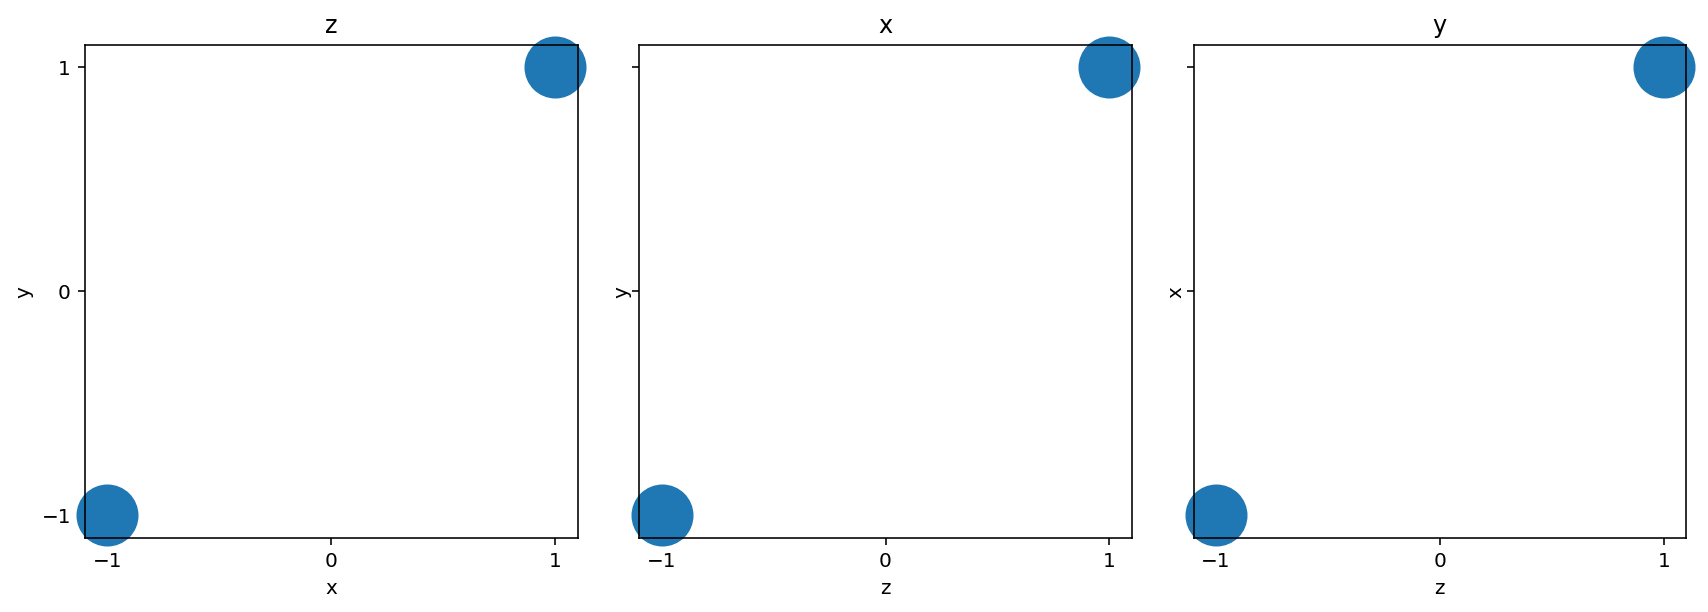

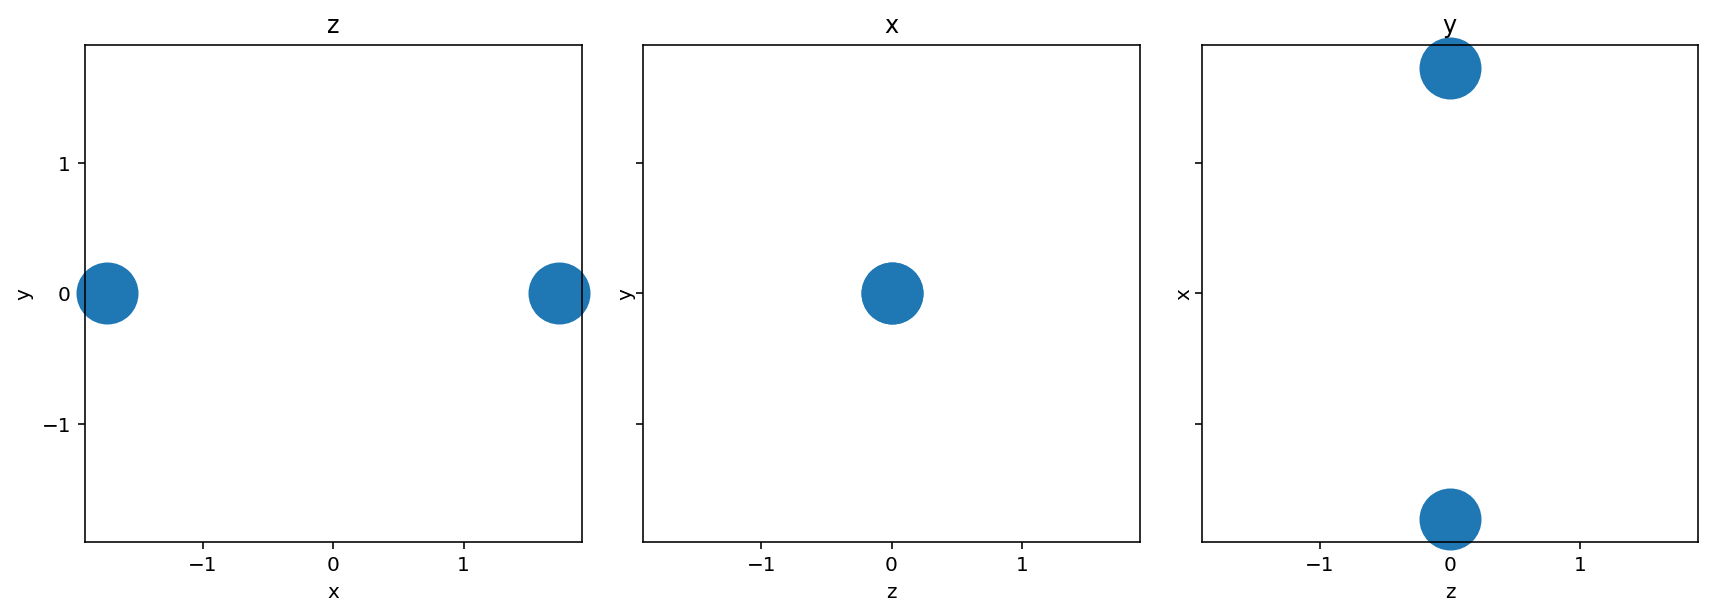

In [22]:
coords, masses = read_molecule_data('rigid_rotor.dat')
coords = move_com_to_origin(coords, masses)
xyz_projections(coords)
I = construct_inertia_matrix(coords, masses)
eigenvalues, eigenvectors = np.linalg.eig(I)
print('eigenvalues=',eigenvalues)
R = np.linalg.inv(eigenvectors)
new_coords = rotate_molecule(coords, R)
xyz_projections(new_coords)

eigenvalues= [1.77129104 0.62093298 1.15035806]


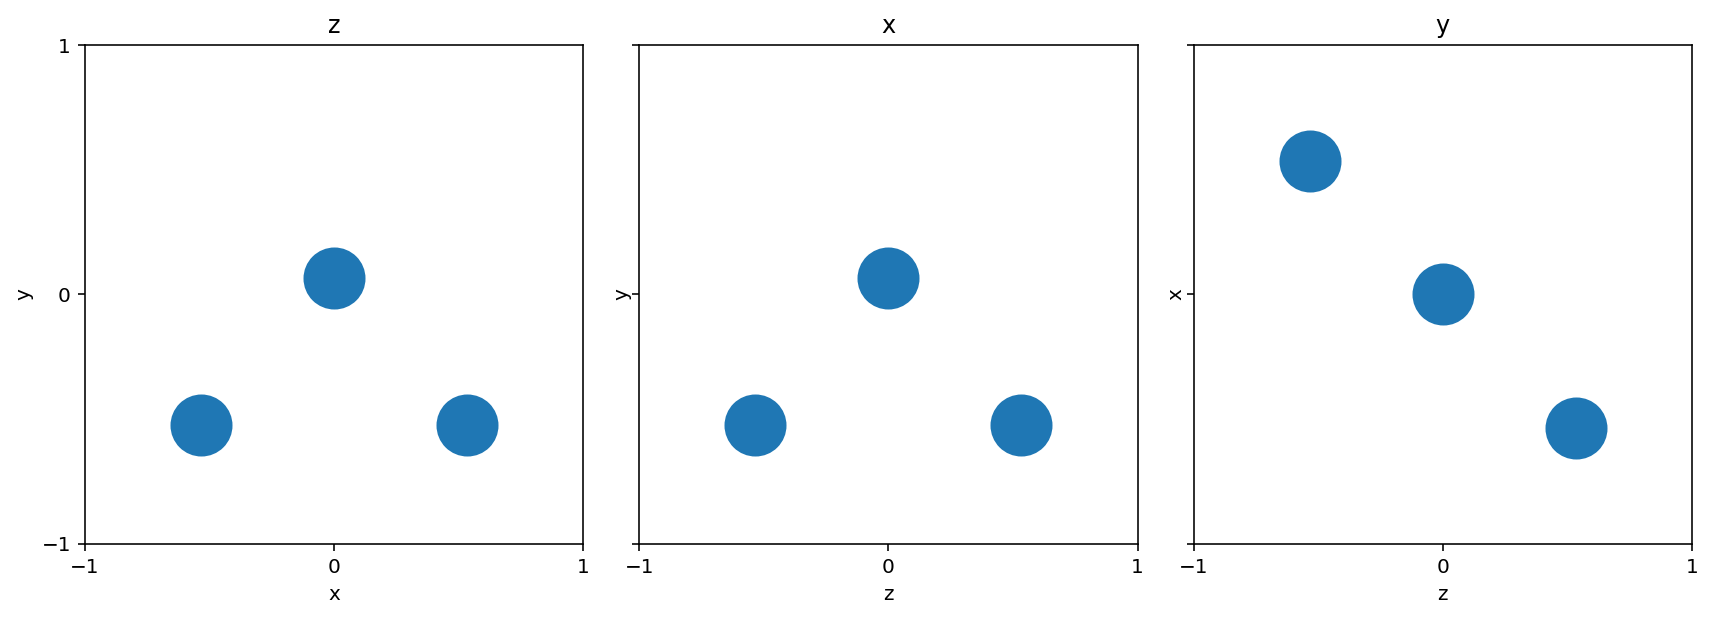

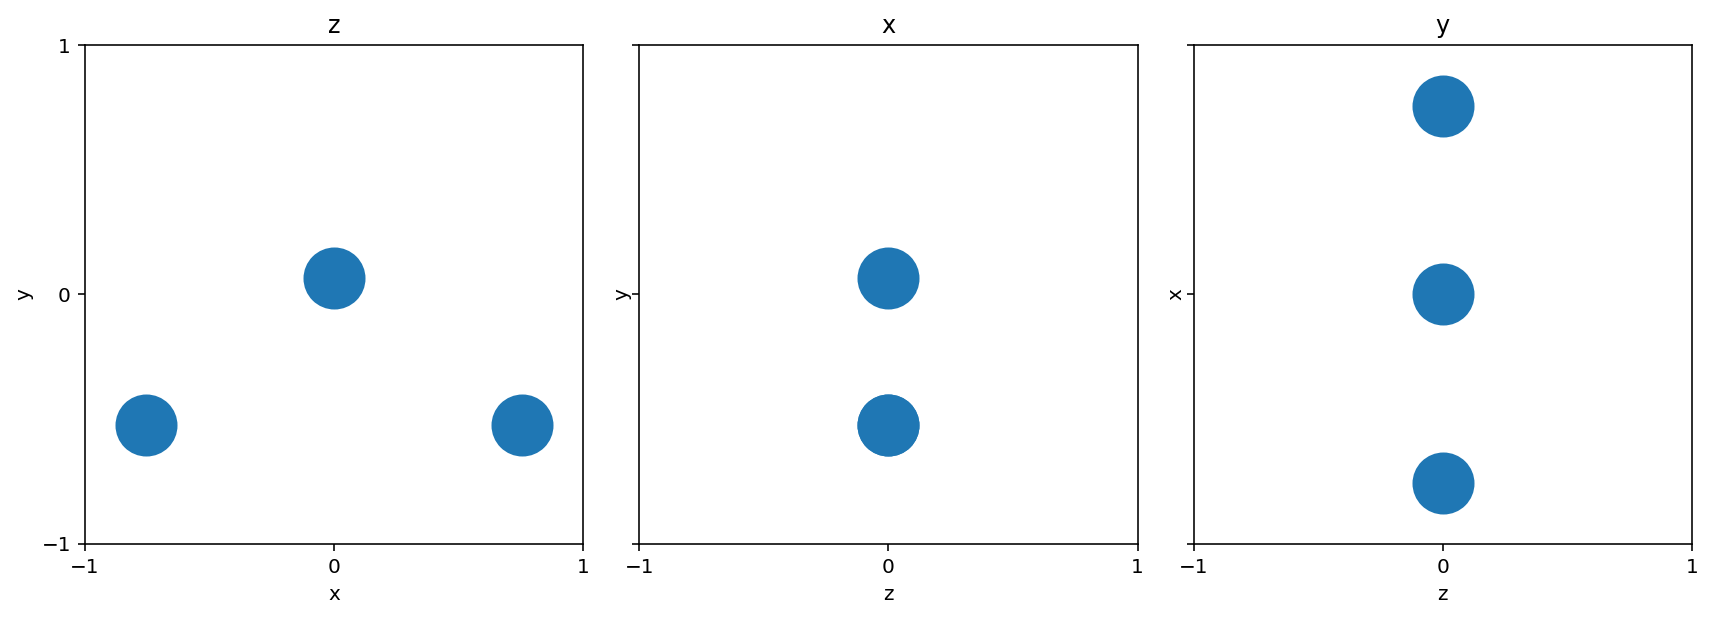

In [23]:
coords, masses = read_molecule_data('water.dat')
coords = move_com_to_origin(coords, masses)
xyz_projections(coords)
I = construct_inertia_matrix(coords, masses)
eigenvalues, eigenvectors = np.linalg.eig(I)
print('eigenvalues=',eigenvalues)
R = np.linalg.inv(eigenvectors)
new_coords = rotate_molecule(coords, R)
xyz_projections(new_coords)

eigenvalues= [3.19459272 1.92482019 1.92617265]


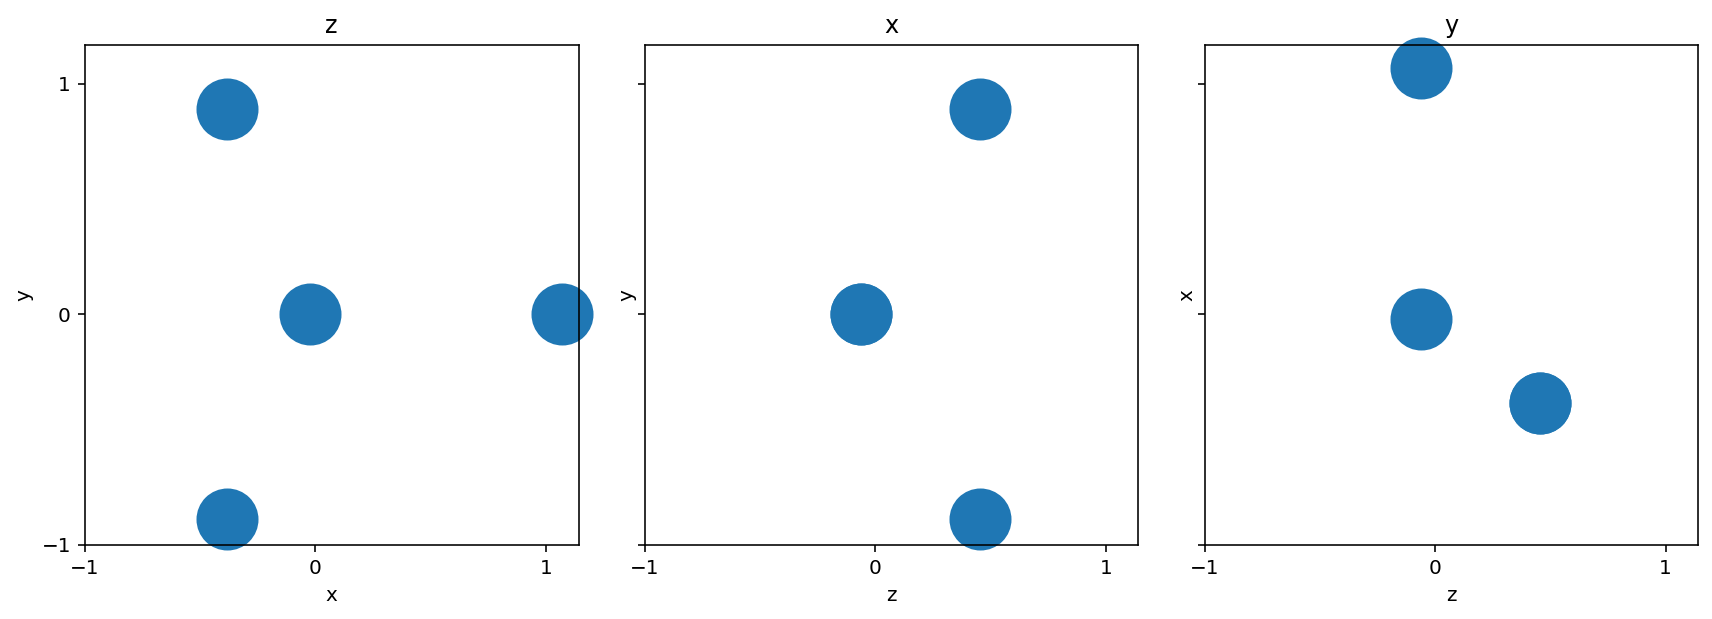

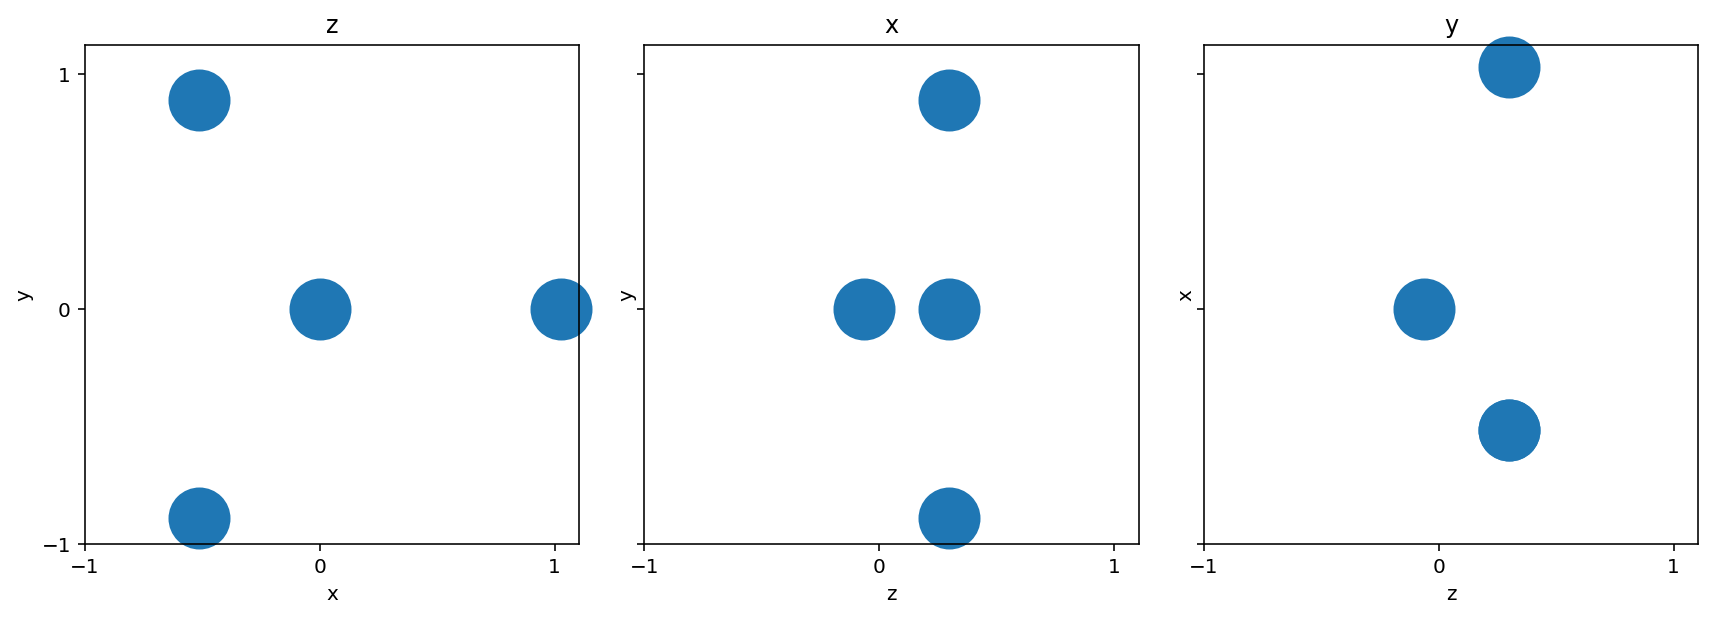

In [24]:
coords, masses = read_molecule_data('ammonia.dat')
coords = move_com_to_origin(coords, masses)
xyz_projections(coords)
I = construct_inertia_matrix(coords, masses)
eigenvalues, eigenvectors = np.linalg.eig(I)
print('eigenvalues=',eigenvalues)
R = np.linalg.inv(eigenvectors)
new_coords = rotate_molecule(coords, R)
xyz_projections(new_coords)

eigenvalues= [ 3.17525838 16.10606541 16.10606543]


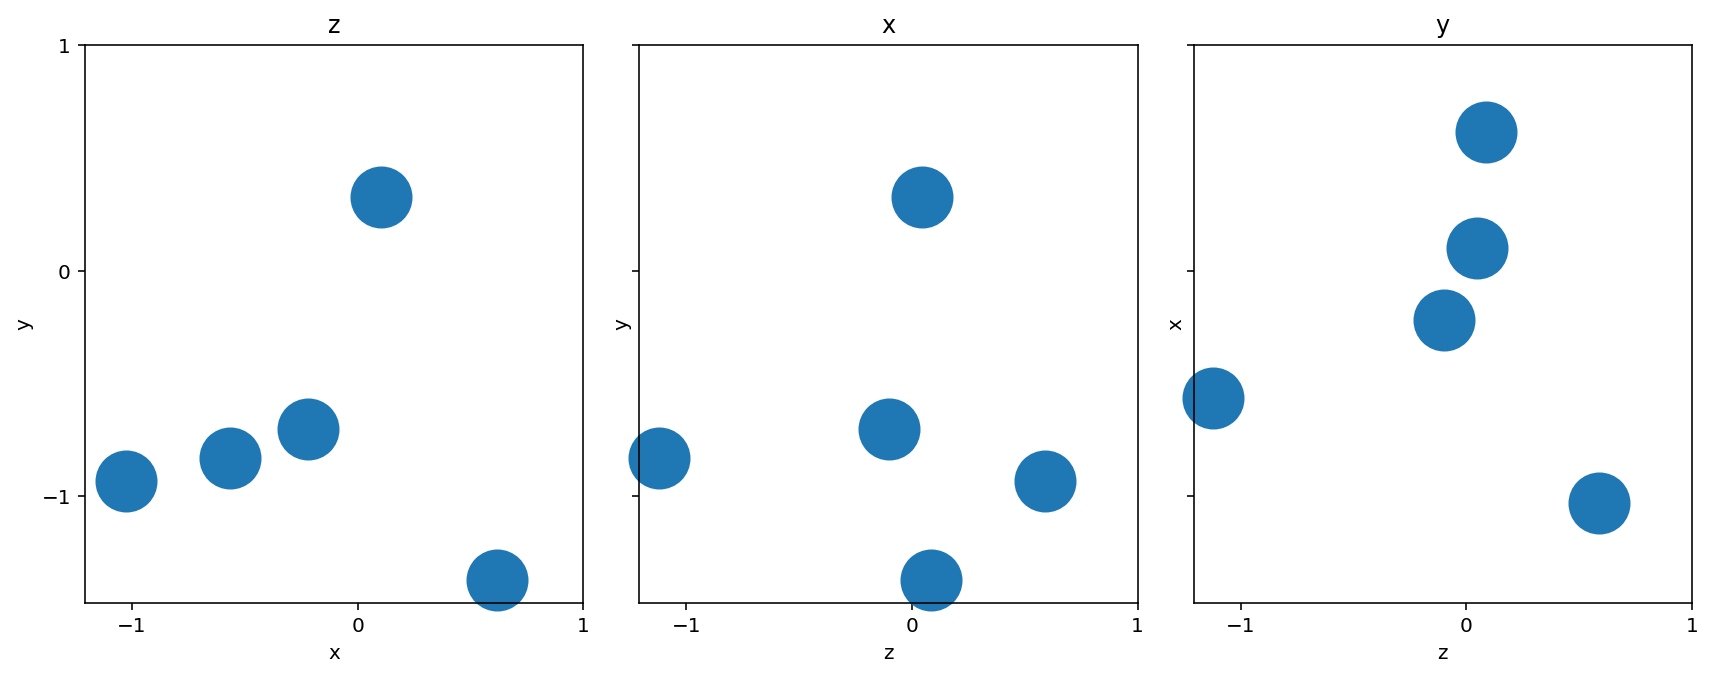

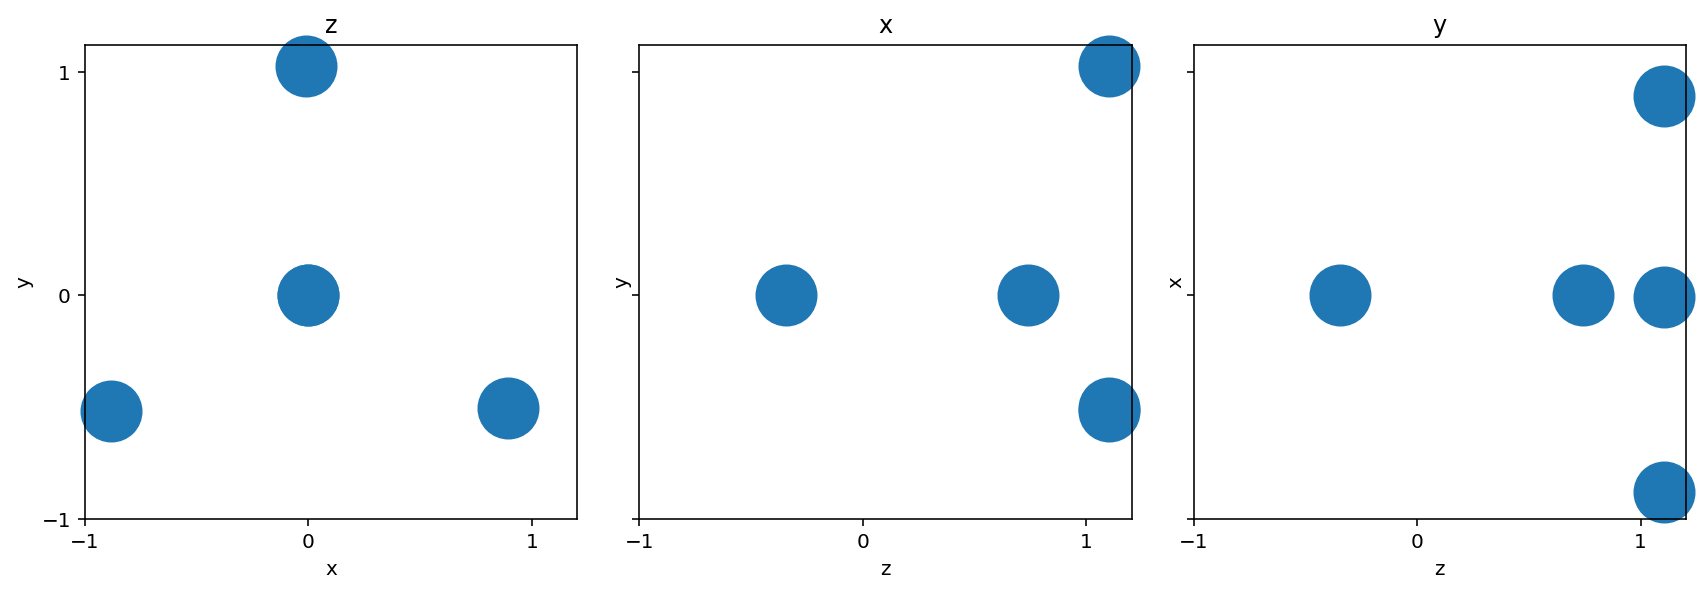

In [25]:
# using chloromethane here.
# CH4 is too high symmetry to define unique rotation axes (at least with the method
# we are using here) so it's possible to get different "correct" answers.
# CH3Cl behaves better.
coords, masses = read_molecule_data('chloromethane.dat')
coords = move_com_to_origin(coords, masses)
xyz_projections(coords)
I = construct_inertia_matrix(coords, masses)
eigenvalues, eigenvectors = np.linalg.eig(I)
print('eigenvalues=',eigenvalues)
R = np.linalg.inv(eigenvectors)
new_coords = rotate_molecule(coords, R)
xyz_projections(new_coords)

In [26]:
# The first projection is now down the Cl–C bond. 
# The other two projections / rotation axes are perpendicular to these.